In [ ]:
import kagglehub
import os
import zipfile

# Download MusicNet( this contains classical music)
musicnet_path = kagglehub.dataset_download("imsparsh/musicnet-dataset")

print("Path to dataset files:", musicnet_path)

#GTZAN(non-classical dataset,small amont of classical also)
non_classical_path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", non_classical_path)

100%|██████████| 21.5G/21.5G [17:39<00:00, 21.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1


100%|██████████| 1.21G/1.21G [00:55<00:00, 23.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
#to explore dataset folders and find audio file paths
import os
import pandas as pd


print("MusicNet Directory Structure:")
print(os.listdir(musicnet_path+"/musicnet/musicnet"))  # Shows the folder contents


import os

print("non classical Directory Structure:")
print(os.listdir(non_classical_path+"/Data/"))  # Shows the folder contents

#genre original
print("genre original fold")
print(os.listdir(non_classical_path+"/Data/genres_original"))  # Shows the folder contents

#see labels
print("MusicNet train labels Directory Structure:")
print(os.listdir(musicnet_path+"/musicnet/musicnet/train_labels"))

df = pd.read_csv(musicnet_path+"/musicnet/musicnet/train_labels/2238.csv")
#print(df.head())

MusicNet Directory Structure:
['train_labels', 'train_data', 'test_labels', 'test_data']
non classical Directory Structure:
['features_30_sec.csv', 'genres_original', 'images_original', 'features_3_sec.csv']
genre original fold
['hiphop', 'jazz', 'disco', 'rock', 'classical', 'metal', 'blues', 'reggae', 'pop', 'country']
MusicNet train labels Directory Structure:
['2422.csv', '2594.csv', '1873.csv', '2221.csv', '1805.csv', '2304.csv', '2357.csv', '2169.csv', '1755.csv', '2390.csv', '2322.csv', '2677.csv', '2633.csv', '2217.csv', '1829.csv', '2150.csv', '2212.csv', '2595.csv', '2618.csv', '1835.csv', '2179.csv', '2611.csv', '2282.csv', '2077.csv', '2482.csv', '2247.csv', '2444.csv', '2490.csv', '2441.csv', '1811.csv', '1828.csv', '2234.csv', '2521.csv', '2083.csv', '1773.csv', '2588.csv', '1751.csv', '1749.csv', '2296.csv', '2603.csv', '2239.csv', '1757.csv', '2292.csv', '2443.csv', '2494.csv', '1764.csv', '2168.csv', '2149.csv', '2573.csv', '2335.csv', '2423.csv', '2127.csv', '2550.csv

In [ ]:
print("MusicNet sample files:", os.listdir(musicnet_path)[:5])  #  .wav audio file names
print("GTZAN sample files:", os.listdir(non_classical_path)[:5])  #genre folder names


MusicNet sample files: ['musicnet.npz', 'musicnet_metadata.csv', 'musicnet', 'musicnet_midis']
GTZAN sample files: ['Data']


In [ ]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

def extract_features(audio_path, label):
    #Extracts MFCC features from an audio file.(mel frequency cepstral coefficients)
    try:
        y, sr = librosa.load(audio_path, sr=22050)  # Load audio file >>>>   here sr = sample rate , y= data
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)  # Extract MFCC features (time and f dependent)
        #print(f"MFCCs before transpose: {mfccs.shape}")
        mfccs = mfccs.T
        #print(f"MFCCs after transpose: {mfccs.shape}")

        max_timesteps = 1300

        if mfccs.shape[0] < max_timesteps:  # If shorter, pad
            pad_width = max_timesteps - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
        else:  # If longer, truncate
            mfccs = mfccs[:max_timesteps, :]

        return mfccs, label
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, None

# Process classical music (MusicNet)
musicnet_audio_dir = os.path.join(musicnet_path, "musicnet/musicnet/train_data")
classical_data = []   #store features data


if os.path.exists(musicnet_audio_dir):
  for file in tqdm(os.listdir(musicnet_audio_dir)):
    #print("executing musicnet audio dir")
    if file.endswith(".wav"):
          filepath = os.path.join(musicnet_audio_dir, file)
          #print(f"Processing {filepath}")
          features, label = extract_features(filepath, label=1)  # 1 = classical

          if features is not None:
              classical_data.append(features)   #str features in the list
          else:
                print(f"Failed to extract features from {filepath}")  # Debug output
else:
    print(f"MusicNet directory not found: {musicnet_audio_dir}")


#print the number of features extracted
print(f"Classical data features: {len(classical_data)}")


100%|██████████| 320/320 [06:51<00:00,  1.29s/it]

Classical data features: 320


In [ ]:
# Process non-classical music (GTZAN)
gtzan_audio_dir = os.path.join(non_classical_path+"/Data", "genres_original")
non_classical_data = []


if os.path.exists(gtzan_audio_dir):
  for genre in os.listdir(gtzan_audio_dir):   #going to sub folders      #'rock', 'jazz', 'disco',...

    print(genre)

    if genre == "classical":
      print("\nskipping classical\n")
      continue      #skip classical data in this because classical data obtained from musicnet dataset
    #print("executing gtzan audio dir

    genre_path = os.path.join(gtzan_audio_dir, genre) #open genre fold
    count =0    #limit the non classical data
    #that is to make the classical and non classical training data to be equally used.

    for file in tqdm(os.listdir(genre_path)):
        #print("executing gtzan audio dir")

        if file.endswith(".wav") and count <40:   #use audio files only
              filepath = os.path.join(genre_path, file)
              features, label = extract_features(filepath, label=0)  # 0 = non-classical

              if features is not None:
                  non_classical_data.append(features)   #str features
                  count+=1
              else:
                  print(f"Failed to extract features from {filepath}")  # Debug output
else:
    print(f"GTZAN directory not found: {gtzan_audio_dir}")

print(f"Non-classical data features: {len(non_classical_data)}")

In [ ]:
import numpy as np
from sklearn.utils import shuffle


#fixed length for MFCC arrays (get rid of music length changes)
fixed_length = 1300

# Pad or truncate each MFCC feature array to the fixed length
def pad_or_truncate_mfcc(mfcc, fixed_length=130):
    # If the length is shorter ->>> pad with zeros
    if mfcc.shape[0] < fixed_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, fixed_length - mfcc.shape[0])), mode='constant')
    # If the length is longer >>>> truncate
    else:
        mfcc = mfcc[:, :fixed_length]
    return mfcc

#handle empty data
if len(classical_data)==0 or len(non_classical_data)==0:
  raise ValueError("Empty data in classical_data or non_classical_data")


# Apply padding/truncation to all data
classical_data = [pad_or_truncate_mfcc(mfcc) for mfcc in classical_data]
non_classical_data = [pad_or_truncate_mfcc(mfcc) for mfcc in non_classical_data]

# make as NumPy arrays
classical_data = np.array(classical_data)  # a list of Mel Spectrograms
non_classical_data = np.array(non_classical_data)

#  1 << classical, 0 << non-classical
classical_labels = np.ones(len(classical_data))  # [1,1,1,...]
non_classical_labels = np.zeros(len(non_classical_data))  # [0,0,0,...]

# Combine features and labels
features = np.concatenate((classical_data, non_classical_data), axis=0)
labels = np.concatenate((classical_labels, non_classical_labels), axis=0)

# Shuffle data
features, labels = shuffle(features, labels, random_state=42)

# Convert labels to integer type
labels = labels.astype(int)

print(f"Features shape: {features.shape}")  # (num_samples, height, width, 1)
print(f"Labels shape: {labels.shape}")  # (num_samples,)


Features shape: (680, 1300, 20)
Labels shape: (680,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Standardization: Normalize each spectrogram to mean=0, std=1
mean_train = np.mean(X_train, axis=(1, 2), keepdims=True)
std_train = np.std(X_train, axis=(1, 2), keepdims=True)
X_train = (X_train - mean_train) / np.where(std_train == 0, 1, std_train)  # Avoid division by zero

mean_test = np.mean(X_test, axis=(1, 2), keepdims=True)
std_test = np.std(X_test, axis=(1, 2), keepdims=True)
X_test = (X_test - mean_test) / np.where(std_test == 0, 1, std_test)  # Avoid division by zero



Training data shape: (544, 1300, 20)
Testing data shape: (136, 1300, 20)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(130,20)),
    BatchNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])


# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Save model
model.save("music_classification_model.h5")

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.8103 - loss: 0.3843 - val_accuracy: 0.7426 - val_loss: 0.6349
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.9953 - loss: 0.0611 - val_accuracy: 0.7574 - val_loss: 0.5989
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.9855 - loss: 0.0606 - val_accuracy: 0.7279 - val_loss: 0.5637
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.9917 - loss: 0.0283 - val_accuracy: 0.8456 - val_loss: 0.4916
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.9916 - loss: 0.0302 - val_accuracy: 0.7059 - val_loss: 0.6125
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.9979 - loss: 0.0119 - val_accuracy: 0.8309 - val_loss: 0.4175
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.9982 - loss: 0.0084 - val_accuracy: 0.8309 - val_loss: 0.3468
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.9984 - loss: 0.0078 - val_accuracy: 0.9118 - v

Test Accuracy: 1.0000


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 8.1823e-04
Test Accuracy: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


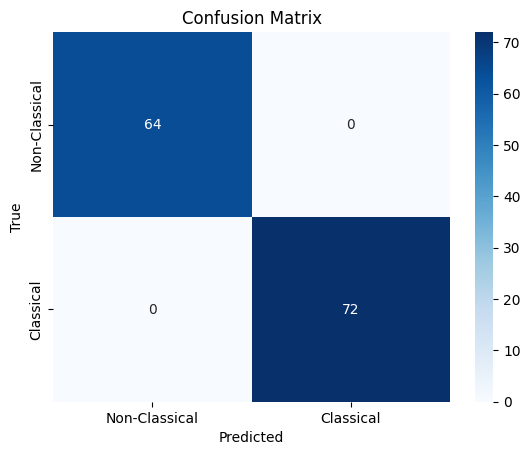

ROC-AUC Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        72

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136



In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Classical', 'Classical'], yticklabels=['Non-Classical', 'Classical'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# ROC-AUC Score
roc_score = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_score:.4f}")

#F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Classification Report
print(classification_report(y_test, y_pred))


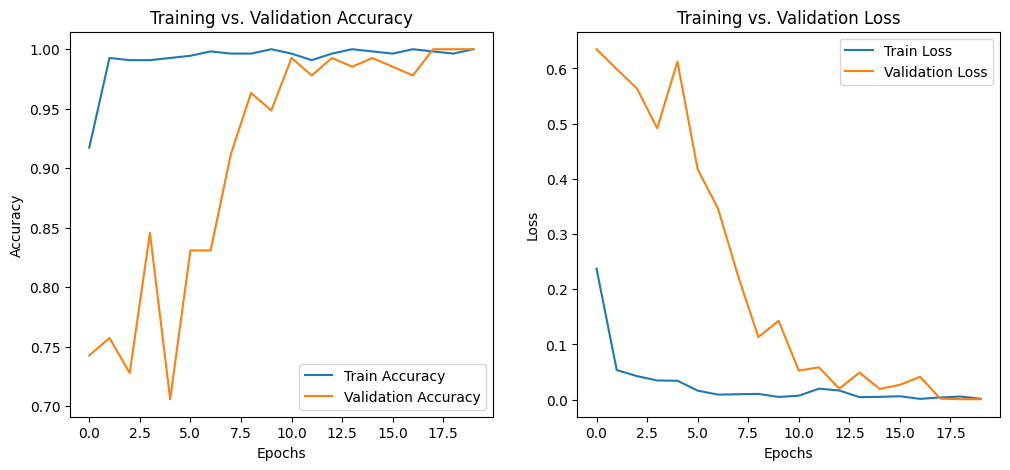

In [ ]:
# Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()


In [ ]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("music_classification_model.h5")

# Check the model summary
loaded_model.summary()

#evaluate model
test_loss, test_acc = loaded_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 130, 256)            │         152,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 130, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 130, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 130, 128)            │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 130, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 130, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 341,379 (1.30 MB)

 Trainable params: 340,545 (1.30 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 2 (12.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 8.1823e-04
Test Accuracy: 1.0000


In [ ]:
#sample test
import sys

audio_path = gtzan_audio_dir+"/classical/classical.00002.wav"
#musicnet_test_audio_dir
audio_path = os.path.join(musicnet_path, "musicnet/musicnet/test_data")
#print(os.listdir(musicnet_dir))
#audio_path = os.path.join(gtzan_audio_dir,"classical")
#audio_path = musicnet_audio_dir+"/classical/00001.wav"
if os.path.exists(audio_path):
  print(f"Audio file found: {audio_path}")
else:
  print(f"Audio file not found: {audio_path}")
  sys.exit("Exiting, file not found!")

def extract_mfcc(audio_path, sr=22050, n_mfcc=20, max_length=130):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)


    # Pad or truncate MFCC to the fixed length
    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]

    mfcc= mfcc.T

    return mfcc

audio_files = os.listdir(audio_path)
#print(audi0_files)


# Extract MFCCs
for audio_file in audio_files:
    audio_pathnew = os.path.join(audio_path, audio_file)
    print(f"Processing {audio_pathnew}")

    if audio_file.endswith(".wav") and os.path.isfile(audio_pathnew):

      mfcc = extract_mfcc(audio_pathnew)

      #print(mfcc.shape)

      # Standardize the MFCC (use the mean and std of the training set)
      mean_train = np.mean(X_train, axis=(1, 2), keepdims=True)
      std_train = np.std(X_train, axis=(1, 2), keepdims=True)
      mfcc = (mfcc - mean_train) / np.where(std_train == 0, 1, std_train)

      mfcc = mfcc[0]
      # Check shape of mfcc
      #print("MFCC Shape:", mfcc.shape)
      print("MFCC Shape before expanding:", mfcc.shape)

      mfcc = np.expand_dims(mfcc, axis=0)

      # Make prediction
      prediction = loaded_model.predict(mfcc)

      # Convert prediction to binary label
      predicted_label = (prediction > 0.5).astype(int)


      # Print the predicted label
      if predicted_label[0] == 1:
          print("Predicted: Classical music")
      else:
          print("Predicted: Non-classical music")

    else:
        # Skip directories or non-wav files
        if os.path.isdir(audio_path):
            print(f"Skipping directory: {audio_path}")
        else:
            print(f"Skipping non-audio file: {audio_path}")

Audio file found: /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/2303.wav
MFCC Shape before expanding: (130, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
Predicted: Classical music
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/2382.wav
MFCC Shape before expanding: (130, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted: Non-classical music
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/2628.wav
MFCC Shape before expanding: (130, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted: Non-classical music
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/1819.wav
MFCC Shape before expanding: (130, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted: Classica